In [1]:
import os
import git
import sys

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(git_root)

from abm_vec.one_period_sim import run_sim
from abm_vec.initialization import get_bank_data

from scipy.optimize import minimize
from scipy.stats import kstest
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from abm_vec.essentials.util import get_git_root_directory
import numpy as np
import random
from scipy import stats
from scipy.stats import anderson_ksamp

In [2]:
bank_data = get_bank_data()

# Minimize KS distance

In [3]:
def fun(x):

    param = {'firm_lb1': x[0],
             'firm_lb2': x[1],
             'firm_ub1': x[2],
             'firm_ub2': x[3],
             'firm_alpha1': x[4],
             'firm_alpha2': x[5],
             'firm_rho': x[6],
             'min_productivity': x[7]}
    results = run_sim(param, copy.deepcopy(bank_data), [1]) 
    empirical_le_ratio = results[0]['banks']['bank_loans'] / results[0]['banks']['bank_equity']
    simulated_le_ratio = results[1]['banks']['bank_loans'] / results[0]['banks']['bank_equity']
    max_diff = kstest(empirical_le_ratio, simulated_le_ratio, alternative='two-sided').statistic 
    return max_diff

In [4]:
bounds = [(5 * 10 ** 5, 5 * 10 ** 6),
          (10 ** 3, 10**4),
          (5 * 10** 7, 30 * 10 ** 7),
          (5 * 10 ** 5, 10 ** 7),
          (0, 3),
          (0, 3),
          (0, 1) ,
          (100, 1000)]#,
          #(50, 2000)]

initial_guess = [10**6, 7500, 15 * 10 ** 7, 0.7 * 10 ** 6, 1.6, 1.7, 0.9, 150]#, 820]


result = minimize(fun, initial_guess, method='Nelder-Mead', bounds=bounds)

In [5]:
optimal_x = result.x

In [6]:
optimal_x

array([9.87030029e+05, 7.81471252e+03, 1.51020813e+08, 6.98611450e+05,
       1.66713867e+00, 1.66508484e+00, 9.37765503e-01, 1.40844727e+02])

In [6]:
optimal_x

array([9.87030029e+05, 7.81471252e+03, 1.51020813e+08, 6.98611450e+05,
       1.66713867e+00, 1.66508484e+00, 9.37765503e-01, 1.40844727e+02])

# Generate 1000 samples and apply the k-sample Anderson test

In [7]:
def fun(x):
    param = {'firm_lb1': x[0],
             'firm_lb2': x[1],
             'firm_ub1': x[2],
             'firm_ub2': x[3],
             'firm_alpha1': x[4],
             'firm_alpha2': x[5],
             'firm_rho': x[6],
             'min_productivity': x[7]}
    random_seeds = random.sample(range(1, 100000), 1000)
    results = run_sim(param, copy.deepcopy(bank_data), random_seeds) 
    empirical_le_ratio = [s[0]['banks']['bank_loans'] / s[0]['banks']['bank_equity'] for s in results]
    simulated_le_ratio = [s[1]['banks']['bank_loans'] / s[0]['banks']['bank_equity'] for s in results]
    return empirical_le_ratio, simulated_le_ratio

In [8]:
empirical_le_ratio, simulated_le_ratio = fun(optimal_x)

In [10]:
res = anderson_ksamp(simulated_le_ratio)

/tmp/ipykernel_21623/2577826661.py:1: UserWarning: p-value capped: true value larger than 0.25
  res = anderson_ksamp(simulated_le_ratio)


In [11]:
res.pvalue

0.25

# KS independent

In [13]:
# ks test
res = [kstest(empirical_le_ratio[0], r, alternative='two-sided').pvalue for r in simulated_le_ratio]

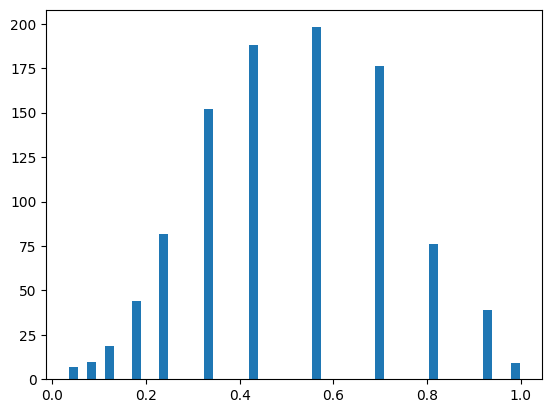

In [14]:
plt.hist(res, bins=50)
plt.show()

# price optimization

In [10]:
def update_param(param, new):
    param_new = param.copy()
    param_new.update(new)
    return param_new

In [11]:
x = np.array([9.87030029 * 10 ** 5, 7.81471252 * 10 ** 3, 1.51020813 * 10 ** 8, 6.98611450 * 10 ** 5,
       1.66713867, 1.66508484e+00, 0.937765503, 1.40844727 * 10 ** 2])

param = {'firm_lb1': x[0],
         'firm_lb2': x[1],
         'firm_ub1': x[2],
         'firm_ub2': x[3],
         'firm_alpha1': x[4],
         'firm_alpha2': x[5],
         'firm_rho': x[6],
         'min_productivity': x[7],
         'market_price': 600,
         "good_consumption": [0.98, 0.94],
         "good_consumption_std": [0.006, 0.006],
         "min_consumption": 0.9,
         "max_consumption": 1}

In [12]:
min_prices_threshold = [run_sim(update_param(param, {'market_price': x}), copy.deepcopy(bank_data), [1])[1]['firms']['min_price_breach'] for x in np.linspace(100, 1000, 20)]

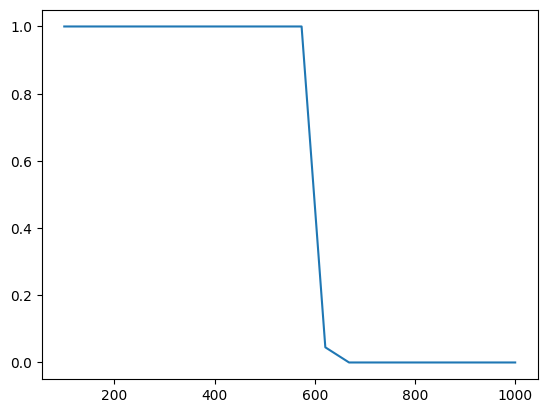

In [13]:
plt.plot(np.linspace(100, 1000, 20), min_prices_threshold)
plt.show()

# Setting $\mu_{goods}$

In [23]:
num_defaulting_banks = [len(run_sim({'good_consumption': [1, x], "min_consumption": 0.0}, copy.deepcopy(bank_data), [1])[1]['firms']["defaulting_firms"]) for x in np.linspace(0.1, 1, 100)]

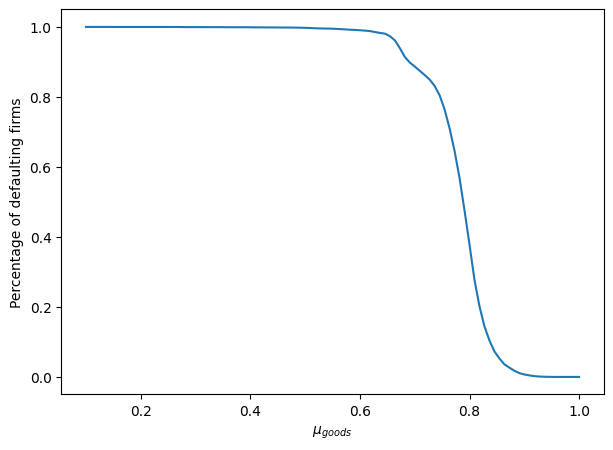

In [33]:
plt.figure(figsize=(7,5))
plt.plot(np.linspace(0.1, 1, 100), [x/10000 for x in num_defaulting_banks])
plt.xlabel('$\mu_{goods}$')
plt.ylabel('Percentage of defaulting firms')
plt.savefig(os.path.join(git_root, 'plots_presentation/percentage_firm_default.png'),bbox_inches='tight', dpi=400, edgecolor='white')
plt.show()

In [28]:
np.linspace(0.1, 1, 100)[-13]

0.8909090909090909